# Technical Metadata Classification

In [1]:
import os
import sys
from pathlib import Path
import itertools

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='01.04-prealn-wf_tech_classification')

# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-03-05 
Git hash: 4796afefa0895931d55d062e3e0486bdb22d8cf4


This is still a work in progress.
In the SRA there is a field called
`library_strategy`.
This field describes what kind of experiment was done (i.e.,
RNA-Seq vs ChIP-Seq vs WGS vs ...).
On the previous page I went through the
process of selecting various metrics in order to try to separate these types of
data.
This is a tricky problem because we would expect most labels to be
correct, and there are some dataset types like RNA-Seq that have thousands of
datasets and other like FAIRE-seq to have few samples.

Here I want to classify
samples using a data driven approach.
I am primarily interested in identifying
samples in `OTHER` that below to RNA-Seq and ChIP-Seq, and removing samples that
are in RNA-Seq but behave badly.
I am using the random forest ensemble approach
because it outputs feature importances and seems to behave pretty well with
these types of data.

In [2]:
# %load ../config/mongo.py
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27022)
db = mongoClient['sra']
ncbi = db['ncbi']

In [3]:
# Grab list of samples that passed merge
samples = store['prealn/merge_passed']
srxs = samples.srx.unique().tolist()
srrs = samples.srr.unique().tolist()
num_samples = samples.shape[0]
idx = samples.set_index(['srx', 'srr']).index

In [4]:
# Pull out current annotations
db_anno = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srxs}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
])))

anno = {}
for i, _df in db_anno.groupby('library_strategy'):
    if len(_df) > 100:
        anno[i] = _df.srx.tolist()

db_anno.set_index('srx', inplace=True)

In [5]:
_df = db_anno.library_strategy.value_counts().to_frame().applymap(lambda x: '{:,}'.format(x))
_df.columns = ['Number of SRXs']
_df.index.name = 'Library Strategy'
Markdown(f"""
**Current Database Annotations**

{_df.to_html(classes='table table-stripped')}

""")


**Current Database Annotations**

<table border="1" class="dataframe table table-stripped">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Number of SRXs</th>
    </tr>
    <tr>
      <th>Library Strategy</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>RNA-Seq</th>
      <td>8,506</td>
    </tr>
    <tr>
      <th>ChIP-Seq</th>
      <td>2,493</td>
    </tr>
    <tr>
      <th>WGS</th>
      <td>1,782</td>
    </tr>
    <tr>
      <th>OTHER</th>
      <td>1,142</td>
    </tr>
    <tr>
      <th>EST</th>
      <td>279</td>
    </tr>
    <tr>
      <th>MNase-Seq</th>
      <td>62</td>
    </tr>
    <tr>
      <th>FAIRE-seq</th>
      <td>17</td>
    </tr>
    <tr>
      <th>DNase-Hypersensitivity</th>
      <td>9</td>
    </tr>
    <tr>
      <th>WGA</th>
      <td>6</td>
    </tr>
    <tr>
      <th>ncRNA-Seq</th>
      <td>5</td>
    </tr>
    <tr>
      <th>POOLCLONE</th>
      <td>4</td>
    </tr>
    <tr>
      <th>AMPLICON</th>
      <td>4</td>
    </tr>
    <tr>
      <th>MeDIP-Seq</th>
      <td>4</td>
    </tr>
    <tr>
      <th>RIP-Seq</th>
      <td>1</td>
    </tr>
    <tr>
      <th>miRNA-Seq</th>
      <td>1</td>
    </tr>
  </tbody>
</table>



## Random Forest

In [6]:
# get features imported and split
features = store.select('/prealn/analysis/tech_metadata_features', 'index == srxs')
X = features.loc[srxs, :]
Y = db_anno.loc[srxs, :]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.library_strategy, test_size=.30)

In [7]:
# Random forest classifier
forest = RandomForestClassifier(n_estimators=10, n_jobs=4, max_depth=4)
forest.fit(X_train, Y_train)

# How does this perform on our test dataset?
_score = forest.score(X_test, Y_test)

Markdown(f"""
I used a 10 tree random forest with the feature sets described on the previous page.
For training the model I am using the database annotations without any kind of curation.
The model performs pretty well with an accuracy of {_score:0.04f}.
The features are printed below in the order of their importance in the model.
""")


I used a 10 tree random forest with the feature sets described on the previous page.
For training the model I am using the database annotations without any kind of curation.
The model performs pretty well with an accuracy of 0.9255.
The features are printed below in the order of their importance in the model.


In [8]:
# Look at feature importance
idx = list(reversed(np.argsort(forest.feature_importances_)))
for i, feature in zip(idx, features.columns[idx]):
    print(f'{feature:20}\t{forest.feature_importances_[i]:8}')

PCT_INTERGENIC_BASES	0.13002385292976654
PERCENT_DUPLICATION 	0.11973775988056982
MEDIAN_CV_COVERAGE  	0.08954102596982563
PCT_UTR_BASES       	0.07760598568957437
PCT_INTRONIC_BASES  	0.07622806148379545
PCT_CODING_BASES    	0.0728580316382952
chrY                	0.07086815876975221
MEDIAN_5PRIME_BIAS  	0.0672472928645347
prop_features_assigned	0.05723230672136961
cv_3Prime           	0.04713213621169092
chrM                	0.03151189937445143
chr3L               	0.030039204216884503
junction_count      	0.029614845793591915
cv_middle           	0.02939785786106989
chrX                	0.0256106995420583
MEDIAN_3PRIME_BIAS  	0.014804104339838597
cv_5Prime           	0.011438502787396611
chr2L               	0.008242064052077981
prop_rRNA           	0.004374571444215224
chr3R               	0.004171826379039444
chr4                	0.0019135534596844118
chr2R               	0.0004062585905172356


In [9]:
# Take all data and get predictions
predictions = forest.predict_proba(X)

res = []
for sample in predictions:
    _sort = np.argsort(sample)
    idx_1 = _sort[-1]
    idx_2 = _sort[-2]
    class_1 = forest.classes_[idx_1]
    prob_1 = sample[idx_1]
    class_2 = forest.classes_[idx_2]
    prob_2 = sample[idx_2]
    res.append([class_1, prob_1, class_2, prob_2])

_dd = pd.DataFrame(res, index=features.index, columns=['class1', 'probClass1', 'class2', 'probClass2'])
_dd.class1.value_counts().to_frame().join(_dd.class2.value_counts().to_frame())

,class1,class2
RNA-Seq,8930,815
ChIP-Seq,2912,1293
WGS,1736,2596
OTHER,737,2060



Finally I take the entire dataset and run the classifier.
In addition to class labels the classifier also abouts a probability score.
I captured the two most likely classes {`class1`, `class2`}.
Finally, I plot the Confusion matrix showing the changes from the database annotations to the predicted class labels.

As expected the low count classes are often relabeld.
I am thinking about enforcing library strategy for the low count classes.
Because of their uniqueness, I expect these specialized classes would be less likely to be wrong.

Using this method, I have identified an additional 167 `OTHER` samples that were classified ChIP-Seq and 130
samples that are now classified as RNA-Seq.



Confusion matrix, without normalization


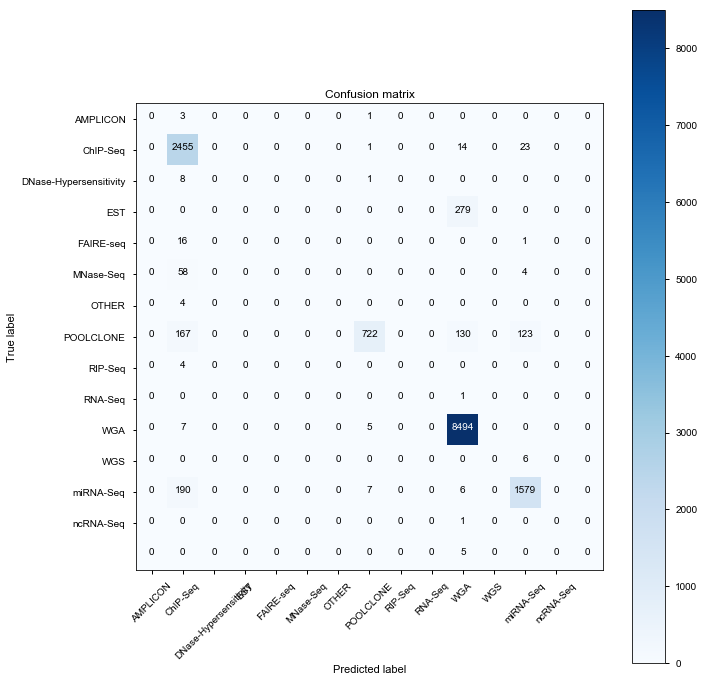

In [11]:
# Look at the confusion matrix to see what is changing
cnf = confusion_matrix(Y.library_strategy, _dd.class1)

display(Markdown(f"""
Finally I take the entire dataset and run the classifier.
In addition to class labels the classifier also abouts a probability score.
I captured the two most likely classes {{`class1`, `class2`}}.
Finally, I plot the Confusion matrix showing the changes from the database annotations to the predicted class labels.

As expected the low count classes are often relabeld.
I am thinking about enforcing library strategy for the low count classes.
Because of their uniqueness, I expect these specialized classes would be less likely to be wrong.

Using this method, I have identified an additional {cnf[7, 1]:,} `OTHER` samples that were classified ChIP-Seq and {cnf[7,10]}
samples that are now classified as RNA-Seq.

"""))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf, forest.classes_)